### Import/Install Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics
import xgboost as xgb

In [3]:
# pandas config

### Read data/ data summary

In [4]:
data = pd.read_csv('./Titanic-Dataset.csv')
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
data['Survived'].value_counts() #class imbalance?

0    549
1    342
Name: Survived, dtype: int64

### Data Preprocessing

In [8]:
#duplicate, fillna/dropna, normalize, split, one-hot-encoding

In [9]:
data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

In [10]:
embarked = pd.get_dummies(data['Embarked'])

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
norm = pd.DataFrame(scaler.fit_transform(data[['Age', 'Fare']]), data.index, columns=['norm_Age', 'norm_Fare'])

In [12]:
data = pd.concat([data.drop(columns=['Embarked', 'Age', 'Fare']), embarked, norm], axis=1)
data['norm_Age'] = data['norm_Age'].fillna(data['norm_Age'].median())
data['Sex'] = np.vectorize(lambda x: True if x == 'male' else False)(data['Sex'])
data.set_index(['PassengerId'], inplace=True)
data.sort_index(inplace=True)
data

,Survived,Pclass,Sex,SibSp,Parch,C,Q,S,norm_Age,norm_Fare
PassengerId,,,,,,,,,,
1,0,3,True,1,0,0,0,1,-0.457653,-0.971698
2,1,1,False,1,0,1,0,0,-0.055542,-0.721729
3,1,3,False,0,0,0,0,1,-0.357125,-0.969063
4,1,1,False,1,0,0,0,1,-0.130937,-0.792711
5,0,3,True,0,0,0,0,1,-0.130937,-0.968575
...,...,...,...,...,...,...,...,...,...,...
887,0,2,True,0,0,0,0,1,-0.331993,-0.949251
888,1,1,False,0,0,0,0,1,-0.533049,-0.882888
889,0,3,False,1,2,0,0,1,-0.306861,-0.908457


In [13]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    bool   
 3   SibSp      891 non-null    int64  
 4   Parch      891 non-null    int64  
 5   C          891 non-null    uint8  
 6   Q          891 non-null    uint8  
 7   S          891 non-null    uint8  
 8   norm_Age   891 non-null    float64
 9   norm_Fare  891 non-null    float64
dtypes: bool(1), float64(2), int64(4), uint8(3)
memory usage: 52.2 KB


In [14]:
# Kfoldcv, as we are not doing splitting

### Classification Model 1 - SVM?

### Classification Model 2 - RandomForest/Gradient Tree Boosting?

In [15]:
param_grid = {
  'n_estimators': [100, 400], #this one is not as important as early stop presents
  'learning_rate':  [0.01, 0.1],
  'max_depth': [4, 5, 6],
  'colsample_bytree':[0.8, 1],
  'gamma':[0],
  # 'scale_pos_weight':[scale],
}

gbc = xgb.XGBClassifier(
    tree_method='auto', device = "cuda",
    random_state=42,
    early_stopping_rounds=42,
    # eval_metric='auc',
    objective='multi:softproba',
    num_class=3,
)

grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring='roc_auc_ovr_weighted',
    cv = 5
    # n_jobs=4,
)

X_train = pd.concat([X_train,X_val])
y_train = pd.concat([y_train,y_val])
grid_search.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    #sample_weight=sample_weights,
)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("The best Parameters are",best_params)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred, normalize='all')

print("Accuracy on Test Data: {:.2f}%".format(accuracy * 100))

NameError: name 'X_train' is not defined

### Classification Model 3 - Decision Tree

In [34]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Assuming 'data' is your dataset

# Define features (x) and target (y)
x = data.drop('Survived', axis=1)
y = data['Survived']

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt'],
    'splitter': ['best', 'random']
}

# Instantiate the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

for k in range(2, 11):
    print(k, '- fold cross validation:')

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=k, scoring='accuracy')

    # Fit GridSearchCV to the training data
    grid_search.fit(x_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Train a new DecisionTreeClassifier with the best hyperparameters
    best_dt = DecisionTreeClassifier(**best_params, random_state=42)
    best_dt.fit(x_train, y_train)

    # Evaluate the model on the training set
    y_train_pred_dt = best_dt.predict(x_train)
    accuracy_train_dt = accuracy_score(y_train, y_train_pred_dt)
    print("Accuracy on Training Set: {:.2f}".format(accuracy_train_dt * 100))

    # Evaluate the model on the test set
    y_test_pred_dt = best_dt.predict(x_test)
    accuracy_test_dt = accuracy_score(y_test, y_test_pred_dt)
    print("Accuracy on Test Set: {:.2f}".format(accuracy_test_dt * 100))


2 - fold cross validation:
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy on Training Set: 83.29
Accuracy on Test Set: 82.12
3 - fold cross validation:
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy on Training Set: 83.57
Accuracy on Test Set: 79.89
4 - fold cross validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy on Training Set: 82.87
Accuracy on Test Set: 79.89
5 - fold cross validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Accuracy on Training Set: 83.57
Accuracy on Test Set: 82.12
6 - fold cross validation:
Best Hyp

In [58]:
# Pick 5-fold Cross Validation

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini'],
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], # 8
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], # 7
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], # 2
    'max_features': [None],
    'splitter': ['best']
}

# Instantiate the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)


print('5- fold cross validation:')

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new DecisionTreeClassifier with the best hyperparameters
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(x_train, y_train)

# Evaluate the model on the training set
y_train_pred_dt = best_dt.predict(x_train)
accuracy_train_dt = accuracy_score(y_train, y_train_pred_dt)
print("Accuracy on Training Set: {:.2f}".format(accuracy_train_dt * 100))

# Evaluate the model on the test set
y_test_pred_dt = best_dt.predict(x_test)
accuracy_test_dt = accuracy_score(y_test, y_test_pred_dt)
print("Accuracy on Test Set: {:.2f}".format(accuracy_test_dt * 100))


5- fold cross validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'best'}
Accuracy on Training Set: 88.06
Accuracy on Test Set: 81.56


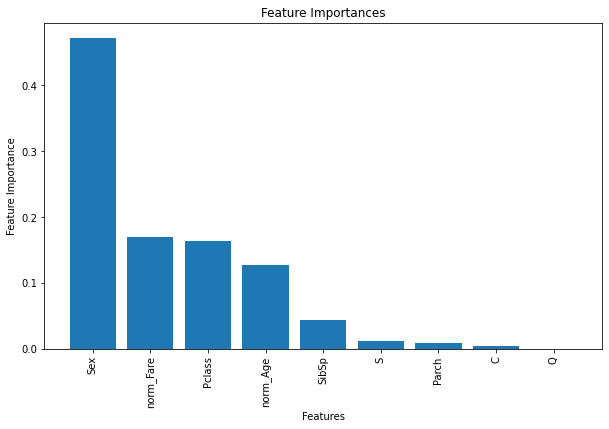

In [59]:
# Get feature importances from the trained model
feature_importances = best_dt.feature_importances_

# Get the names of features
feature_names = x.columns  # Assuming X is your feature matrix, and you have column names

# Sort indices of feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

### Result/Analysis/Visualization